In [1]:
import os

import torch
import torch.utils.data as torch_data

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from fastmri.utils import load_torch_model, fastMRIData, compare_imgs
from fastmri.model import UnetGenerator

In [2]:
def print_metrics(mae, psnr, ssim):
    print('\t\tMAE\tPSNR\tSSIM')
    print(f'\tscore\t{mae:.4f}\t{psnr:.4f}\t{ssim:.4f}')

In [3]:
acceleration = 4

PATH_TO_GENERATOR = f'models/G_x{acceleration}.pth'

PATH_TO_SOURCE_TRAIN = 'data/ax_t2_single_source_train'
PATH_TO_SOURCE_VAL = 'data/ax_t2_single_source_val'
PATH_TO_SOURCE_TEST = 'data/ax_t2_single_source_test'

PATH_TO_SAMPLED_TRAIN = f'data/ax_t2_single_sampled_x{acceleration}_train'
PATH_TO_SAMPLED_VAL = f'data/ax_t2_single_sampled_x{acceleration}_val'
PATH_TO_SAMPLED_TEST = f'data/ax_t2_single_sampled_x{acceleration}_test'

device = torch.device('cpu')

In [4]:
fmri_train = fastMRIData(PATH_TO_SOURCE_TRAIN, PATH_TO_SAMPLED_TRAIN)
fmri_val = fastMRIData(PATH_TO_SOURCE_VAL, PATH_TO_SAMPLED_VAL)
fmri_test = fastMRIData(PATH_TO_SOURCE_TEST, PATH_TO_SAMPLED_TEST)

fmri_train.images = fmri_train.images
fmri_val.images = fmri_val.images
fmri_test.images = fmri_test.images

train_loader = torch_data.DataLoader(fmri_train, batch_size=10, num_workers=4)
val_loader = torch_data.DataLoader(fmri_val, batch_size=10, num_workers=4)
test_loader = torch_data.DataLoader(fmri_test, batch_size=10, num_workers=4)

In [5]:
generator_state = torch.load(PATH_TO_GENERATOR)

G = UnetGenerator()
G.load_state_dict(generator_state)

loaders = [train_loader, val_loader, test_loader]
names = ['Train', 'Val', 'Test']

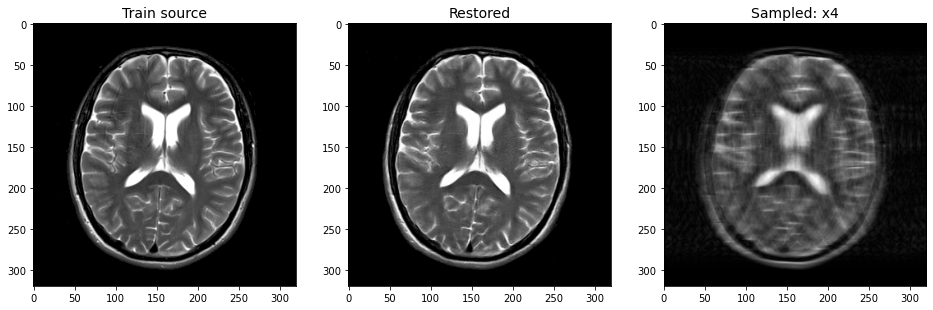

Source & Sampled:
	MAE	PSNR	SSIM
score	0.056	20.741	0.612

Source & Restored:
	MAE	PSNR	SSIM
score	0.019	28.175	0.934


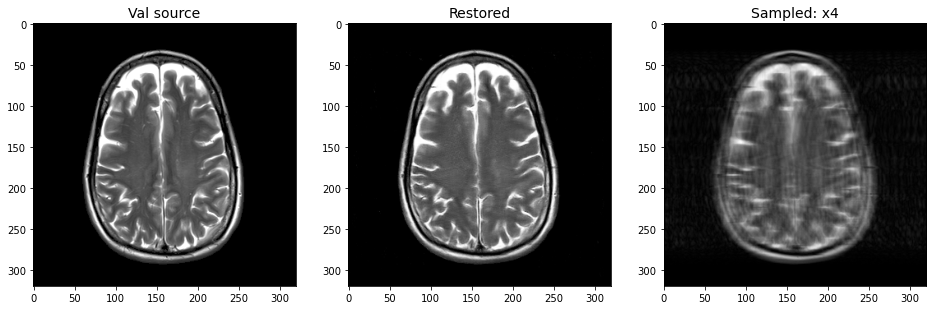

Source & Sampled:
	MAE	PSNR	SSIM
score	0.056	20.311	0.584

Source & Restored:
	MAE	PSNR	SSIM
score	0.018	28.004	0.953


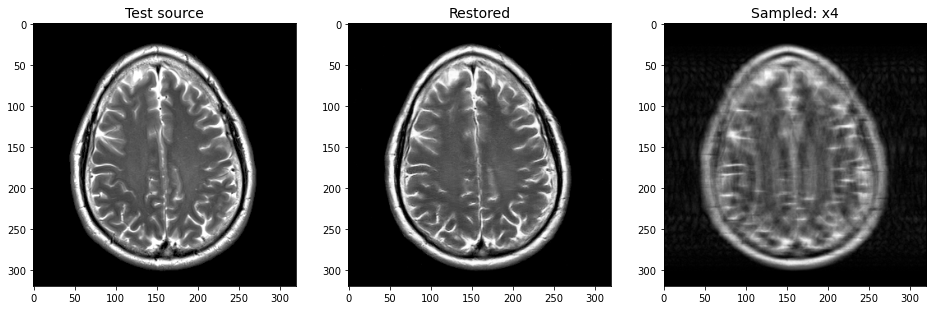

Source & Sampled:
	MAE	PSNR	SSIM
score	0.064	19.811	0.571

Source & Restored:
	MAE	PSNR	SSIM
score	0.022	27.156	0.944


In [6]:
for fmri, name in zip([fmri_train, fmri_val, fmri_test], names):

    i = np.random.randint(0, len(fmri))
    source, sampled = fmri.__getitem__(i)

    restored = G(sampled.reshape(1, 1, 320, 320)).data

    fig, axis = plt.subplots(1, 3, figsize=(16, 10))
    axis[0].imshow(source[0], cmap='gray', vmin=0, vmax=1)
    axis[0].set_title(f'{name} source', fontsize=14)
    axis[1].imshow(restored.squeeze(), cmap='gray', vmin=0, vmax=1)
    axis[1].set_title(fr'Restored', fontsize=14)
    axis[2].imshow(sampled[0], cmap='gray', vmin=0, vmax=1)
    axis[2].set_title(f'Sampled: x{acceleration}', fontsize=14)

    plt.show()

    print('Source & Sampled:')
    compare_imgs(source, sampled, verbose=True)
    print('\nSource & Restored:')
    compare_imgs(source, restored[0].data, verbose=True)

In [7]:
%%time

results = dict()

for data_loader, name in zip(loaders, names):

    mae = []
    psnr = []
    ssim = []

    for sources, sampled in tqdm(data_loader):

        G.to(device)
        sampled.to(device)

        restored = G(sampled).data

        for source, restored_one in zip(sources, restored):
            res = compare_imgs(source, restored_one, verbose=False)

            mae.append(res[0])
            psnr.append(res[1])
            ssim.append(res[2])

    results[name] = {'mae': np.mean(mae), 'psnr': np.mean(psnr), 'ssim': np.mean(ssim)}


CPU times: user 8h 38min 14s, sys: 37min 34s, total: 9h 15min 49s
Wall time: 2h 19min 43s


In [8]:
for part_name, res in results.items():
    print(part_name + ':')

    values = list(res.values())
    print_metrics(*values)

Train:
		MAE	PSNR	SSIM
	score	0.0199	27.9460	0.9408
Val:
		MAE	PSNR	SSIM
	score	0.0199	27.8623	0.9390
Test:
		MAE	PSNR	SSIM
	score	0.0200	27.8528	0.9391
